
## Analytic Solutions Convergence Tests

This notebook runs series of simulations across different resolutions to extract error convergence information. Analytic Stokes flow solutions are used as a basis for error estimation. 

See `2_19_Analytic Solutions 2D.ipynb` for visualisation of individual models.

In [1]:
from collections import OrderedDict as OD
regress_solns = [
#   ("name", {soln_params}, {solver_tolerances} )
    ("A"   , OD([("sigma_0",1.),  ("n_x",1), ("n_z",1.0), ("eta_0",1.) ]), 
            {"itol":1.e-2, "otol":1.e-2} ),
#     ("B"   , OD([("sigma_0",1.),  ("n_x",1), ("n_z",1.5), ("eta_0",1.) ]), 
#              {"itol":1.e-4, "otol":1.e-4} ),
#     ("C"   , OD([("sigma_0",1000.),  ("x_c",0.5),   ("eta_0",1.) ]), 
#              {"itol":1.e-4, "otol":1.e-4} ),
#     ("DA"  , OD([("sigma_0",1000.),  ("x_c",0.375), ("x_w",0.25), ("eta_A",1.), ("eta_B",10.), ("z_c",0.75) ]), 
#              {"itol":1.e-9, "otol":1.e-9} ),
#     ("H"   , OD([("sigma_0",1000.),  ("x_c",0.5), ("y_c",0.5), ("eta_0",1.)]), 
#              {"itol":1.e-7, "otol":1.e-7} ),
    ("Kx"  , OD([("sigma_0",1.),  ("n_x",1), ("n_z",1.0), ("B",1.151) ]), 
             {"itol":1.e-4, "otol":1.e-4} ),
#     ("Kz"  , OD([("sigma_0",1.),  ("n_x",1), ("n_z",1.0), ("B",1.151) ]), 
#             {"itol":1.e-4, "otol":1.e-4} ),
#     ("M"   , OD([("r",1.5), ("n_x",1), ("n_z",1),   ("eta_0",1.) ]), 
#              {"itol":1.e-6, "otol":1.e-6} ),
#     ("NL"  , OD([("r",1.5), ("n_z",1), ("eta_0",1.) ]), 
#              {"itol":1.e-8, "otol":1.e-8} ),
    ("Cx,1", OD([("n_x",1), ("eta_A",1.), ("eta_B",1.e6), ("x_c",0.50) ]), 
             {"itol":1.e-2, "otol":1.e-2} ),
    ("Cx,2", OD([("n_x",1), ("eta_A",1.), ("eta_B",1.e8), ("x_c",0.75) ]), 
             {"itol":1.e-9, "otol":1.e-9} ),
#     ("DB2d", OD([]), 
#            {"itol":1.e-6, "otol":1.e-6} ),
]

regress_res = [8,16,32]

if len(regress_res)<2:
    raise RuntimeError("At least 2 resolutions required for regression analysis.")

In [2]:
import underworld as uw
uw.timing.start()
import glucifer
from underworld import function as fn
import math
import numpy as np
import collections

uw.matplotlib_inline()

In [3]:
# Find all available 2D solutions. 
# Use ordered dict to preserve alphabetical ordering
solns_avail = collections.OrderedDict()
for soln_name in dir(fn.analytic):
    if soln_name[0] == "_": continue  # if private member, ignore
    # get soln class
    soln = getattr(fn.analytic,soln_name)
    # check if actually soln
    if issubclass(soln, fn.analytic._SolBase):
        # construct
        solnguy = soln()
        print("Solution added: {}".format(soln_name))
        solns_avail[soln_name] = soln

Solution added: SolA
Solution added: SolB
Solution added: SolC
Solution added: SolCx
Solution added: SolDA
Solution added: SolDB2d
Solution added: SolDB3d
Solution added: SolH
Solution added: SolKx
Solution added: SolKz
Solution added: SolM
Solution added: SolNL


In [4]:
solns = collections.OrderedDict()
for sol in regress_solns:
    solname = "Sol"+sol[0]
    solns[solname] = solns_avail[solname.split(',')[0]](**sol[1])
    solns[solname].parameters = sol[1]   # record this for the table later
    solns[solname].tolerances = sol[2]   # record required tolerances as well

In [5]:
# Create the tools we need

def get_numerical( soln, res=32, order=1, itol=1.e-6, otol=1.e-6 ):
    '''
    Creates the numerical system corresponding to the provided analytic system.
    
    Parameters
    ----------
    soln : uw.function.analytic._SolBase
        The analytic system
    res : int
        System resolution. Same resolution is used for each axis.
    order : int
        System numerical order. 
    itol : float
        Inner solve tolerance.
    otol : float
        Outer solve tolerance.

        
    '''
    if order == 1:
        els = "Q1/dQ0"
    elif order == 2:
        els = "Q2/dPc1"
    else:
        raise ValueError("Provided system order should be 1 or 2.")

    dim = soln.dim
    mesh  = uw.mesh.FeMesh_Cartesian(elementType=els, elementRes=(res,)*dim,minCoord=(0.,)*dim,maxCoord=(1.,)*dim)
    vel   = uw.mesh.MeshVariable(mesh,dim)
    press = uw.mesh.MeshVariable(mesh.subMesh, 1)
    vel.data[:]   = (0.,)*dim
    press.data[:] = 0.

    bcs = soln.get_bcs(vel)
    
    stokes = uw.systems.Stokes(vel,press,soln.fn_viscosity,fn_bodyforce=soln.fn_bodyforce, conditions=[bcs,])
    solver = uw.systems.Solver(stokes)
    if uw.mpi.size==1:
        solver.set_inner_method("lu")
    solver.set_inner_rtol(itol)
    solver.set_outer_rtol(otol)

    return mesh, vel, press, solver

def calibrate_press(press, press_analytic):
    '''
    Numerical pressure is only provided up to an arbitrary
    constant. This function returns a calibrated version
    of the numerical solution to allow useful comparisons.
    '''
    # note we really should do this on root proc, then broadcast offset
    coord = press.mesh.data[0]
    offset = press.data[0] - press_analytic.evaluate(tuple(coord))
    return press - offset[0]

def rms_error(numeric, analytic, mesh):
    '''
    Calculates the rms error.
    
    Returns
    -------
    err: float
        The absolute rms error.
    '''

    delta     = analytic - numeric
    delta_dot = fn.math.dot(delta,delta)

    analytic_dot = fn.math.dot(analytic,analytic)
    
    # l2 norms
    rms_err_abs = math.sqrt(uw.utils.Integral( delta_dot, mesh ).evaluate()[0])
        
    return rms_err_abs

### Now perform convergence rate tests 

In [6]:
# Note that default parameters have been used for all solns.
# Default parameters are chosen such that all interfaces 
# fall on element boundaries when power of 2 mesh resolutions 
# are chosen.
velocity_key = "Velocity"
pressure_key = "Pressure"

resolutions = regress_res
dx = np.reciprocal(resolutions,dtype='double')

soln_results = collections.OrderedDict()

for soln_name in solns.keys():
    solnguy = solns[soln_name]
    print("Performing simulations for solution: {}".format(soln_name))

    for order in [1,2]:
        err_pre = collections.OrderedDict()
        err_vel = collections.OrderedDict()

        for res in resolutions:
            mesh, vel, press, solver = get_numerical( solnguy, res, order=order, **solnguy.tolerances )
            solver.solve()
    
            # tether numerical to analytic pressure somewhere
            press = calibrate_press(press, solnguy.fn_pressure)

            err_vel[res] = rms_error(   vel, solnguy.fn_velocity, mesh )
            err_pre[res] = rms_error( press, solnguy.fn_pressure, mesh )

            soln_results[(soln_name,order, velocity_key)] = err_vel
            soln_results[(soln_name,order, pressure_key)] = err_pre


Performing simulations for solution: SolA
Performing simulations for solution: SolKx
Performing simulations for solution: SolCx,1
Performing simulations for solution: SolCx,2


In [7]:
fitfn = lambda x,a,b: a+b*x
def get_linear_fit(x,y):
    '''
    Returns best fit (a,b) for $ln(y)=a+b*ln(x)$ for provided
    set of points (x,y).
    '''
    import scipy.optimize
    return scipy.optimize.curve_fit(fitfn,  np.log(x),  np.log(y))

def get_fit_line(dx, fit):
    '''
    Evaluates fit across a set of points.
    '''
    dxmin = 0.9*dx.min()
    dxmax = 1.1*dx.max()
    xpts = np.linspace(dxmin,dxmax,20)
    ypts = np.exp(fitfn(np.log(xpts),*fit))
    return xpts, ypts

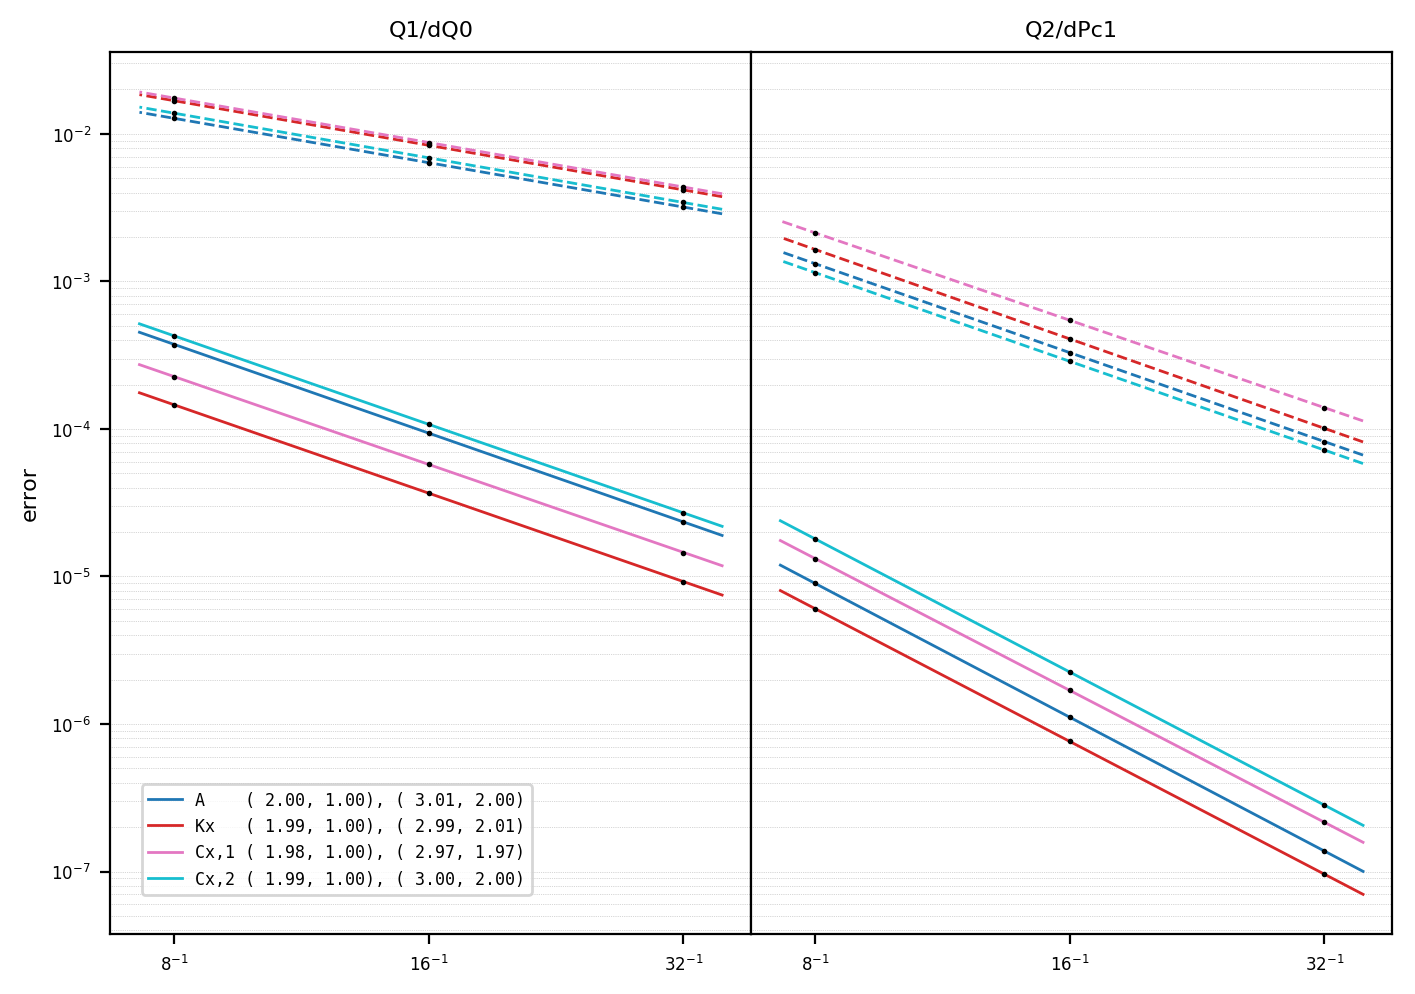

In [8]:
if uw.mpi.rank==0:
    import matplotlib.pyplot as plt
    fig = plt.figure(dpi=200, figsize=(8.27, 11.69/2.))
    plt.subplots_adjust(wspace=.0)
    
    # create some consistent colours & linestyles
    from matplotlib.pyplot import cm
    colours = cm.tab10(np.linspace(0,1,len(solns.keys())))
    scheme = {}
    for it,sol in enumerate(solns.keys()):
        scheme[(sol,pressure_key)] = (colours[it],'--')
        scheme[(sol,velocity_key)] = (colours[it],'-')


    def create_ax(pos, title=None, other_ax=None):
        ax = plt.subplot(1,2,pos,xscale='log', yscale='log', sharey=other_ax)
        ax.set_title(title,fontsize=8)
        ax.invert_xaxis()
        ax.xaxis.set_ticks(dx)
        ax.xaxis.set_ticklabels(["$ {{ {} }}^{{-1}}$".format(x) for x in resolutions])
        ax.grid(axis="y", which="both",linestyle=':',linewidth=0.25)
        ax.tick_params(axis='both', which='major', labelsize=8)
#         ax.set_xlabel("dx", fontsize=8)
        if not other_ax:
            ax.set_ylabel("error", fontsize=8)

        # disable minor ticks marks on axis
        for tic in ax.xaxis.get_minor_ticks() + ax.yaxis.get_minor_ticks():
            tic.tick1On = tic.tick2On = False
            tic.label1On = tic.label2On = False
        for tic in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
            tic.label.set_fontsize(6)
        # disable tick marks on rhs of other axis
        if other_ax:
            for tic in ax.yaxis.get_major_ticks():
                tic.tick1On = tic.tick2On = False
                tic.label1On = tic.label2On = False
        return ax
    
    axes = {}
    axes[1] = create_ax(1, title="Q1/dQ0")
    axes[2] = create_ax(2, title="Q2/dPc1", other_ax=axes[1] )
    
    # get fit results now so we can set plot labels
    fits = {}
    errs = {}
    for key, err in soln_results.items():
        fits[key], errs[key] = get_linear_fit(dx,list(err.values()))

    # keep set of lines for legend
    lines = collections.OrderedDict()
    for key, err in soln_results.items():
        soln_name = key[0]
        order     = key[1]
        velpres   = key[2]
        ax        = axes[order]
        fit       = fits[key]
        fitdata   = get_fit_line(dx,fit)    

        expected_order = order if (key[2]==pressure_key) else order+1
        if not np.isclose(fit[1],expected_order,atol=1.5e-1):
            raise RuntimeError("Rejecting {} fit = {}, expected = {}.".format(soln_name,fit[1],expected_order))

        col,ls = scheme[(soln_name,velpres)]
        line = ax.plot(*fitdata, linewidth=1., color=col, linestyle=ls)
        if velpres == velocity_key:
            lines[soln_name] = line
        
        ax.plot(dx, err.values(), 'o', markersize=1., color='black')

    lbls = []
    lns = []
    for soln_name in lines.keys():
        vel_1   = fits[(soln_name,1,velocity_key)][1]
        pre_1   = fits[(soln_name,1,pressure_key)][1]
        vel_2   = fits[(soln_name,2,velocity_key)][1]
        pre_2   = fits[(soln_name,2,pressure_key)][1]
        lbls.append("{} ({: .2f},{: .2f}), ({: .2f},{: .2f})".format(soln_name[3:].ljust(4), vel_1, pre_1, vel_2, pre_2))
        lns.append(lines[soln_name][0])
    
    fig.legend( lns, lbls, loc = (0.1, 0.1), prop={'family': 'monospace', 'size':6})